# Residential Building Demand Flexibility Modeling

Keywords: residential building, demand flexibility, thermostatically controlled loads (TCLs)

This notebook demonstrates the use of Python library Pandas and Numpy to develop a set of models of thermostatically controlled loads (TCLs).

# Thermostatically Controlled Loads (TCLs) Model
This notebook demonstrates the development of thermostatically controlled loads, including air-conditioners, refrigerators, and electric water heaters.

In [1]:
from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import csv
import datetime


In order to model the demand response potential of load aggregations in residential buildings, first we will consider individual load models. Specifically, we focus our attention on thermostatically controlled loads (TCLs). TCLs such as refrigerators, water heaters and heating ventilation anda air conditioning (HVAC) systems are good candidates for demand side flexibility due to several factors: (i) they can be modeled using physics based models, (ii) they can be interrupted without any hinderance to their end-users, (iii) most of them are available to control signals 24/7. We will use a hybrid two state model to capture individual dynamics of each TCL \cite{Callaway,Kara,Mathieu}. Using these models, we will systematically derive the demand response flexibility for each load when a demand response event is initiated by thermostatic set-point adjustment. We will define flexibility of each load $i$ at any given time step $t$ for a set-point change of $\gamma$ as $f_{i,t}^{\gamma}$. 

The individual hybrid model that captures the underlying thermal dynamics of each TCL is given as follows:

$\theta_{i,t+1}=\alpha_i \theta_{i,t}+ (1-\alpha_i)(\theta^a_{i,t}-m_{i,t}\theta^g_{i})+\epsilon_{i,t}$

where $\theta_{i,t}$ is the interior temperature, $\theta^a_{i,t}$ is the ambient temperature at time $t$,$\theta^g_{i}$ is the heat gain, $m_{i,t}$ is a switch parameter representing ON/OFF state of the TCL and $\alpha$ is a parameter that captures the termal parameters of each TCL as follows:

$\alpha{i}=e^{-h /{C_iR_i}}$

where R_i and C_i are thermal resistance and capacitance respectively.
At any given point in time $t$, a TCL's operation can be interrupted by a set-point adjustment. When used to trigger demand response events, set-point adjustments results in TCLs switching OFF due to the change in thermostatic control bounds governing its interior temperature. Once the TCL is switched OFF, it remains OFF untill the interior temperature reaches the new thermostatic control bound that triggers switching from OFF to ON. To formalize this concept, let us define $\theta^s_{i,t}$ as the set-point for TCL $i$ at time $t$ and $\delta$ as the deadband width of the $i$th TCLs thermostatic bound. Due to a set-point adjustment of $\gamma$, $\theta^s_{i,t+1}$ can be defined as follows:

$\theta^s_{i,t+1}=\theta^s_{i,t} + \gamma$

Using the equation for individual load dynamics, one can define the $f_{i,t}^{\gamma}$ as the time that each TCL would take to switch back $ON$ if it were to be $OFF$ at any given time step $t$. For every time step $t$ one can estimate $f_{i,t}^{\gamma}$ for different $\gamma$ values. For cooling loads, $f_{i,t}^{\gamma}$ can be defined as:

$f_{i,t}^{\gamma}=-R_iC_i \ln(\frac{\theta^s_{i,t} + \gamma + \delta/2 - \theta^a_{i,t}}{\theta_{i,t}-\theta^a_{i,t}})$

Similarly, for cooling loads, the time that the TCL would take to switch back OFF when it was ON can be calculated as:

$f_{i,t}^{\gamma}=-R_iC_i \ln(\frac{\theta^s_{i} + \gamma - \delta/2 - \theta^a_{i} + P_{i}R_{i}}{\theta_{i}-\theta^a_{i}+ P_{i}R_{i}})$

Using this definition and parameters obtained from the literature on heterogenous load characteristics, we can simulate a population of TCLs composed of individual models in a bottom up fashion. 




In [2]:
#Parameters for individual TCLs from Rongxin

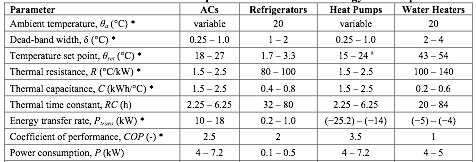

In [2]:
from IPython.display import Image 
Image(filename='data/chapter3/TCL_parameters.png')

In [66]:
#Let's define a class for each TCL
def get_t_off(R,C,setpoint,deadbandwidth,ambient,current,gamma=0,cooling=True):
    if current==ambient:
        t_off=24
    else:
        if cooling==True:
            t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))
        else:
            t_off=-1*R*C*np.log((setpoint+gamma-deadbandwidth/2-float(ambient))/(current-float(ambient)))
    if t_off<0:
        t_off=np.nan
    return t_off
 
class Airconditioner(object):
    """
    A refrigerator class 

    """
    class_counter= 0
    def __init__(self, timestep,ambient_temp=20,cooling=True,err_sigma=0.01):
        
        """Return a Customer object whose name is *name* and starting
        balance is *balance*."""
        self.type='Airconditioner'
        Airconditioner.class_counter +=1
        self.id='AC'+str(Airconditioner.class_counter)
        self.cooling=cooling
        self.timestep = timestep #Has to be in hours        
        self.resistance= np.random.uniform(1.5,2.5,1)[0]
        self.capacitance= np.random.uniform(1.5,2.5,1)[0]
        self.power=np.random.uniform(4,7.2,1)[0]
        self.cop=2.5
        self.status=np.random.random_integers(0,1,1)[0]
        self.coolingpower=self.power*self.cop
        self.deadbandwidth=np.random.uniform(0.25,1,1)[0]       
        self.setpoint=np.random.uniform(18,27,1)[0]        
        self.interior_temp=np.random.uniform(self.setpoint-self.deadbandwidth/2,self.setpoint+self.deadbandwidth/2,1)[0]
        self.ambient_temp=ambient_temp
        self.toff=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,0,self.cooling)
        self.toff_1=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,1,self.cooling)
        self.toff_2=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,2,self.cooling)
        self.toff_3=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,3,self.cooling)

        self.err_sigma=err_sigma
        
        if self.cooling:
            self.gain=self.coolingpower*self.resistance
        else:
            self.gain=-1*self.coolingpower*self.resistance

        self.setpoint_DR=self.setpoint 
        self.interior_temp_DR=self.interior_temp
        self.status_DR=self.status
        self.curTempNoise=np.random.normal(0, self.err_sigma, 1)[0]
       
    def next_interior(self):
        """Return the next timestep interior temperature"""
        #Implement thermostatic action:
        self.curTempNoise=np.random.normal(0, self.err_sigma, 1)[0]
        if self.cooling:
            if self.ambient_temp>self.interior_temp:
                if self.interior_temp<=(self.setpoint-self.deadbandwidth/2):
                    self.status=0
                if self.interior_temp>=(self.setpoint+self.deadbandwidth/2):
                    self.status=1
            else:
                self.status=0
        else: # if it is a heating device.
            if self.ambient_temp<self.interior_temp:
                if self.interior_temp<=(self.setpoint-self.deadbandwidth/2):
                    self.status=1
                if self.interior_temp>=(self.setpoint+self.deadbandwidth/2):
                    self.status=0
            else:
                self.status=0
        alpha=np.exp(-1*self.timestep/(self.capacitance*self.resistance))
        self.interior_temp=self.interior_temp*alpha+(1-alpha)*(self.ambient_temp-(self.status*self.gain))+self.curTempNoise


    def get_toff(self):
        """Return t_off given gamma"""
        self.toff=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,0,self.cooling)
        self.toff_1=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,1,self.cooling)
        self.toff_2=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,2,self.cooling)
        self.toff_3=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,3,self.cooling)

    def changeDRSetPoint(self,newSetPoint):
        """Assign a DR setpoint"""
        self.setpoint_DR=newSetPoint
        
    def next_interior_DR(self):
        """Return the next timestep interior temperature"""
        #Implement thermostatic action:
        if self.cooling:
            if self.ambient_temp>self.interior_temp_DR:
                if self.interior_temp_DR<=(self.setpoint_DR-self.deadbandwidth/2):
                    self.status_DR=0
                if self.interior_temp_DR>=(self.setpoint_DR+self.deadbandwidth/2):
                    self.status_DR=1
            else:
                self.status_DR=0
        else: # if it is a heating device.
            if self.ambient_temp<self.interior_temp_DR:
                if self.interior_temp_DR<=(self.setpoint_DR-self.deadbandwidth/2):
                    self.status_DR=1
                if self.interior_temp_DR>=(self.setpoint_DR+self.deadbandwidth/2):
                    self.status_DR=0
            else:
                self.status_DR=0

              
        alpha=np.exp(-1*self.timestep/(self.capacitance*self.resistance))
        self.interior_temp_DR=self.interior_temp_DR*alpha+(1-alpha)*(self.ambient_temp-(self.status_DR*self.gain))+self.curTempNoise#+np.random.normal(0, self.err_sigma, 1)[0]

class Refrigerator(object):
    """
    A refrigerator class 

    """
    class_counter= 0
    def __init__(self, timestep,ambient_temp=20,cooling=True,err_sigma=0.01):
        
        """Return a Customer object whose name is *name* and starting
        balance is *balance*."""
        self.type='Refrigerator'
        Refrigerator.class_counter +=1
        self.id='REF'+str(Refrigerator.class_counter)
        self.cooling=cooling
        self.timestep = timestep #Has to be in hours
        self.resistance= np.random.uniform(80,100,1)[0]
        self.capacitance= np.random.uniform(0.4,0.8,1)[0]
        self.power=np.random.uniform(0.1,0.5,1)[0]
        self.cop=2
        self.status=np.random.random_integers(0,1,1)[0]
        self.coolingpower=self.power*self.cop
        self.deadbandwidth=np.random.uniform(1,2,1)[0]
        self.setpoint=np.random.uniform(1.7,3.3,1)[0]
        self.interior_temp=np.random.uniform(self.setpoint-self.deadbandwidth/2,self.setpoint+self.deadbandwidth/2,1)[0]
        self.ambient_temp=ambient_temp
        self.toff=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,0,self.cooling)
        self.toff_1=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,1,self.cooling)
        self.toff_2=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,2,self.cooling)
        self.toff_3=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,2,self.cooling)
        self.err_sigma=err_sigma
        
        if self.cooling:
            self.gain=self.coolingpower*self.resistance
        else:
            self.gain=-1*self.coolingpower*self.resistance

        self.setpoint_DR=self.setpoint 
        self.interior_temp_DR=self.interior_temp
        self.status_DR=self.status
        self.curTempNoise=np.random.normal(0, self.err_sigma, 1)[0]

    def next_interior(self):
        """Return the next timestep interior temperature"""
        self.curTempNoise=np.random.normal(0, self.err_sigma, 1)[0]
        if self.cooling:
            if self.ambient_temp>self.interior_temp:
                if self.interior_temp<=(self.setpoint-self.deadbandwidth/2):
                    self.status=0
                if self.interior_temp>=(self.setpoint+self.deadbandwidth/2):
                    self.status=1
            else:
                self.status=0
        else: # if it is a heating device.
            if self.ambient_temp<self.interior_temp:
                if self.interior_temp<=(self.setpoint-self.deadbandwidth/2):
                    self.status=1
                if self.interior_temp>=(self.setpoint+self.deadbandwidth/2):
                    self.status=0
            else:
                self.status=0
        alpha=np.exp(-1*self.timestep/(self.capacitance*self.resistance))
        self.interior_temp=self.interior_temp*alpha+(1-alpha)*(self.ambient_temp-(self.status*self.gain))+self.curTempNoise

    def get_toff(self):
        """Return t_off given gamma"""
        self.toff=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,0,self.cooling)
        self.toff_1=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,1,self.cooling)
        self.toff_2=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,2,self.cooling)
    
    def changeDRSetPoint(self,newSetPoint):
        """Assign a DR setpoint"""
        self.setpoint_DR=newSetPoint
        
    def next_interior_DR(self):
        """Return the next timestep interior temperature"""
        #Implement thermostatic action:
        if self.cooling:
            if self.ambient_temp>self.interior_temp_DR:
                if self.interior_temp_DR<=(self.setpoint_DR-self.deadbandwidth/2):
                    self.status_DR=0
                if self.interior_temp_DR>=(self.setpoint_DR+self.deadbandwidth/2):
                    self.status_DR=1
            else:
                self.status_DR=0
        else: # if it is a heating device.
            if self.ambient_temp<self.interior_temp_DR:
                if self.interior_temp_DR<=(self.setpoint_DR-self.deadbandwidth/2):
                    self.status_DR=1
                if self.interior_temp_DR>=(self.setpoint_DR+self.deadbandwidth/2):
                    self.status_DR=0
            else:
                self.status_DR=0

              
        alpha=np.exp(-1*self.timestep/(self.capacitance*self.resistance))
        self.interior_temp_DR=self.interior_temp_DR*alpha+(1-alpha)*(self.ambient_temp-(self.status_DR*self.gain))+self.curTempNoise

class Waterheater(object):
    """
    A Waterheater class 

    """
    class_counter= 0
    def __init__(self, timestep,ambient_temp=20,cooling=False,err_sigma=0.01):
        
        """Return a Customer object whose name is *name* and starting
        balance is *balance*."""
        self.type='Waterheater'
        Waterheater.class_counter +=1
        self.id='WH'+str(Waterheater.class_counter)
        self.cooling=cooling
        self.timestep = timestep #Has to be in hours
        self.resistance= np.random.uniform(100,140,1)[0]
        self.capacitance= np.random.uniform(0.2,0.6,1)[0]
        self.power=np.random.uniform(4,5,1)[0]
        self.cop=1
        self.status=np.random.random_integers(0,1,1)[0]

        self.coolingpower=self.power*self.cop
        self.deadbandwidth=np.random.uniform(2,4,1)[0]
        self.setpoint=np.random.uniform(43,54,1)[0]
        self.interior_temp=np.random.uniform(self.setpoint-self.deadbandwidth/2,self.setpoint+self.deadbandwidth/2,1)[0]
        self.ambient_temp=ambient_temp
        self.toff=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,0,self.cooling)
        self.toff_1=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,1,self.cooling)
        self.toff_2=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,2,self.cooling)
        self.err_sigma=err_sigma
        
        if self.cooling:
            self.gain=self.coolingpower*self.resistance
        else:
            self.gain=-1*self.coolingpower*self.resistance

        self.setpoint_DR=self.setpoint 
        self.interior_temp_DR=self.interior_temp
        self.status_DR=self.status
        self.curTempNoise=np.random.normal(0, self.err_sigma, 1)[0]

    def next_interior(self):
        """Return the next timestep interior temperature"""
        #Implement thermostatic action:
        self.curTempNoise=np.random.normal(0, self.err_sigma, 1)[0]
        if self.cooling:
            if self.ambient_temp>self.interior_temp:
                if self.interior_temp<=(self.setpoint-self.deadbandwidth/2):
                    self.status=0
                if self.interior_temp>=(self.setpoint+self.deadbandwidth/2):
                    self.status=1
            else:
                self.status=0
        else: # if it is a heating device.
            if self.ambient_temp<self.interior_temp:
                if self.interior_temp<=(self.setpoint-self.deadbandwidth/2):
                    self.status=1
                if self.interior_temp>=(self.setpoint+self.deadbandwidth/2):
                    self.status=0
            else:
                self.status=0
        alpha=np.exp(-1*self.timestep/(self.capacitance*self.resistance))
        self.interior_temp=self.interior_temp*alpha+(1-alpha)*(self.ambient_temp-(self.status*self.gain))+self.curTempNoise


    def get_toff(self):
        """Return t_off given gamma"""
        self.toff=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,0,self.cooling)
        self.toff_1=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,-1,self.cooling)
        self.toff_2=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,-2,self.cooling)
    
    def changeDRSetPoint(self,newSetPoint):
        """Assign a DR setpoint"""
        self.setpoint_DR=newSetPoint
        
    def next_interior_DR(self):
        """Return the next timestep interior temperature"""
        #Implement thermostatic action:
        if self.cooling:
            if self.ambient_temp>self.interior_temp_DR:
                if self.interior_temp_DR<=(self.setpoint_DR-self.deadbandwidth/2):
                    self.status_DR=0
                if self.interior_temp_DR>=(self.setpoint_DR+self.deadbandwidth/2):
                    self.status_DR=1
            else:
                self.status_DR=0
        else: # if it is a heating device.
            if self.ambient_temp<self.interior_temp_DR:
                if self.interior_temp_DR<=(self.setpoint_DR-self.deadbandwidth/2):
                    self.status_DR=1
                if self.interior_temp_DR>=(self.setpoint_DR+self.deadbandwidth/2):
                    self.status_DR=0
            else:
                self.status_DR=0

              
        alpha=np.exp(-1*self.timestep/(self.capacitance*self.resistance))
        self.interior_temp_DR=self.interior_temp_DR*alpha+(1-alpha)*(self.ambient_temp-(self.status_DR*self.gain))+self.curTempNoise


## SAMPLE SIMULATIONS OF AN INDIVIDUAL CLASS

In [ ]:
### Air conditioner simulations

# Read the weather data
weather_df = pd.read_csv('data/chapter3/chapter3.2/Weather_Data.csv', index_col=0, 
                         parse_dates=True)

# Remove the duplicate index
weather_df = weather_df[~weather_df.index.duplicated(keep='first')]
# Reindex the weather data to period 01/01/2021  00:00:00
weather_df.index = pd.date_range(start='2021-01-01 00:00:00', periods=len(weather_df), freq='15min')

# Convert OAT to numeric
weather_df['OAT'] = pd.to_numeric(weather_df['OAT'], errors='coerce')

print(weather_df.head())
print(weather_df.info())

# Select a random day i.e. 2021-07-01
random_day = weather_df.loc['2021-07-01']

# Resample the random day to 1-minute frequency
random_day = random_day.resample('1min').ffill()

# Resample the weather data to 2-minute frequency
# This will forward fill the data to ensure no NaN values
WeatherDF_2Min = weather_df.resample('2min').ffill()

                       OAT
2021-01-01 00:00:00  3.300
2021-01-01 00:15:00  2.500
2021-01-01 00:30:00  1.700
2021-01-01 00:45:00  0.900
2021-01-01 01:00:00  0.925
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35040 entries, 2021-01-01 00:00:00 to 2021-12-31 23:45:00
Freq: 15min
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   OAT     35040 non-null  float64
dtypes: float64(1)
memory usage: 547.5 KB
None


/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1517167470.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_df = pd.read_csv('data/chapter3/chapter3.2/Weather_Data.csv', index_col=0,


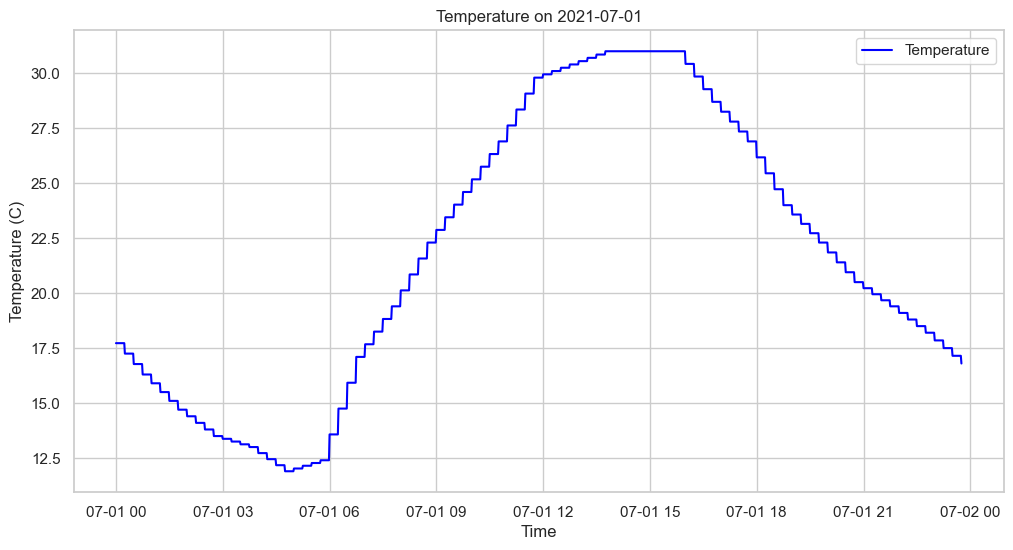

In [60]:
# Use seaborn to plot the temperature
sns.set_context('notebook')
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))
plt.plot(random_day.index, random_day['OAT'], label='Temperature', color='blue')
plt.title('Temperature on 2021-07-01')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

### Start a group of air conditioners simulation

In [87]:
def getHour(row):
    return row['Date'].hour

#Initialize individual TCLs
number_of_tcls=100
step=2 #in minutes
timestep=step/60 #in hours
#duration=3 #in hours
### KEEP THESE THE SAME
EventHourResultsList=[]

# SetPointChanges=[-1,-2,-3,1,2,3]
SetPointChanges=[2]

StartDates=[datetime.datetime(year=2021,month=7,day=1,hour=0,minute=0)]

for SetPointChange in SetPointChanges:
    #duration=range(0,60*duration,step)
    EventHours=range(6,22,1)
    for EventHour in EventHours:
        dayStartTimes=[0,(24)*60,(48)*60,(72)*60,(96)*60,(120)*60,(144)*60] # in minutes
        eventStartTimes=[EventHour*60]
        for days in range(1,7,1):
            eventStartTimes=eventStartTimes+[EventHour*60+720*days] # in minutes 
        print(eventStartTimes)
        eventEndTimes=[elem+60 for elem in eventStartTimes]    
        for startDate in StartDates:
            results=[]
            curDate=startDate
            # GET WEATHER FOR A WEEK FROM THE STARTING DATE:
            endDate=startDate.replace(day=7,hour=23,minute=58)
            print(endDate)
            WeatherSelected=WeatherDF_2Min.loc[startDate:endDate].sort_index()
            print(len(WeatherSelected)/720)
            list_of_tcls=[]
            
            # INITIALIZE A SET OF TCLs 
            for elem in range(number_of_tcls):
                #list_of_tcls.append(Refrigerator(timestep))
                #list_of_tcls.append(Waterheater(timestep))
                list_of_tcls.append(Airconditioner(timestep,ambient_temp=elem))
            ####
            
            hr=0
            i=0
            for ambtemp in WeatherSelected['OAT']: 
                #Initailize at the begining of every day
                if i in dayStartTimes:
                    list_of_tcls=[]
                    # INITIALIZE A SET OF TCLs 
                    for elem in range(number_of_tcls):
                        #list_of_tcls.append(Refrigerator(timestep))
                        #list_of_tcls.append(Waterheater(timestep))
                        list_of_tcls.append(Airconditioner(timestep,ambient_temp=ambtemp))


                if i in eventStartTimes:
                    print('changing setpoint')
                    for ref in list_of_tcls:
                        ref.changeDRSetPoint(ref.setpoint+SetPointChange)

                if i in eventEndTimes:
                    print('changing setpoint')
                    for ref in list_of_tcls:
                        ref.changeDRSetPoint(ref.setpoint)

                if i % 60 == 0:
                    hr=hr+1
                    print('Simulated '+str(hr)+' hours.')

                for ref in list_of_tcls:
                    if ref.type=='Airconditioner':
                        ref.ambient_temp=float(ambtemp)
                    #ref.get_toff()
                    ref.next_interior()
                    ref.next_interior_DR()

                    resDict={}
                    resDict['InteriorTemp']=ref.interior_temp
                    resDict['InternalTempDR']=ref.interior_temp_DR
                    resDict['Resistance']=ref.resistance
                    resDict['Capacitance']=ref.capacitance
                    resDict['DeadBandWidth']=ref.deadbandwidth

                    #toff_ref.append(ref.toff)
                    resDict['AmbientTemp']=ref.ambient_temp
                    resDict['CurrentPower']=ref.power*ref.status
                    resDict['CurrentPowerDR']=ref.power*ref.status_DR
                    resDict['DRPercent']=((ref.power*ref.status_DR)-(ref.power*ref.status))*100/ref.power #DR-Nominal
                    resDict['RatedPower']=ref.power
                    resDict['SetPoint']=ref.setpoint
                    resDict['SetPointDR']=ref.setpoint_DR
                    resDict['Type']=ref.type
                    resDict['Id']=ref.id
                    resDict['Minute']=i
                    resDict['Date']=curDate
                    resDict['SetPointChange']=SetPointChange
                    results.append(resDict)
                curDate=curDate+datetime.timedelta(minutes=step)
                i=i+step
            results=pd.DataFrame(results)   
            AverageDRPercent=results.groupby(['Date'])['DRPercent'].mean()
            AverageDRPercent=pd.DataFrame(AverageDRPercent).reset_index()
            AverageDRPercentOAT=pd.merge(AverageDRPercent,results[['Date','AmbientTemp']],on=['Date'])
            AverageDRPercentOAT.set_index('Date',inplace=True)
            AverageDRPercentOAT=AverageDRPercentOAT.resample('h').mean() # Average over the hour
            AverageDRPercentOAT=AverageDRPercentOAT.reset_index()

            AverageDRPercentOAT['Hour']=AverageDRPercentOAT.apply(getHour,axis=1)
            EHResult=AverageDRPercentOAT[AverageDRPercentOAT['Hour']==EventHour]
            EHResult['SetPointChange']=SetPointChange
            EventHourResultsList.append(EHResult)
        
DRPercentHourlyOATResults=pd.concat(EventHourResultsList)
DRPercentHourlyOATResults.to_pickle('ACSetPointOATDRFirstWeekOfMultiDayTest.pkl')


[360, 1080, 1800, 2520, 3240, 3960, 4680]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
changing setpoint
Simulated 7 hours.
changing setpoint
Simulated 8 hours.
Simulated 9 hours.
Simulated 10 hours.
Simulated 11 hours.
Simulated 12 hours.
Simulated 13 hours.
Simulated 14 hours.
Simulated 15 hours.
Simulated 16 hours.
Simulated 17 hours.
Simulated 18 hours.


/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


changing setpoint
Simulated 19 hours.
changing setpoint
Simulated 20 hours.
Simulated 21 hours.
Simulated 22 hours.
Simulated 23 hours.
Simulated 24 hours.
Simulated 25 hours.
Simulated 26 hours.
Simulated 27 hours.
Simulated 28 hours.
Simulated 29 hours.
Simulated 30 hours.
changing setpoint
Simulated 31 hours.
changing setpoint
Simulated 32 hours.
Simulated 33 hours.
Simulated 34 hours.
Simulated 35 hours.
Simulated 36 hours.
Simulated 37 hours.
Simulated 38 hours.
Simulated 39 hours.
Simulated 40 hours.
Simulated 41 hours.
Simulated 42 hours.
changing setpoint
Simulated 43 hours.
changing setpoint
Simulated 44 hours.
Simulated 45 hours.
Simulated 46 hours.
Simulated 47 hours.
Simulated 48 hours.
Simulated 49 hours.
Simulated 50 hours.
Simulated 51 hours.
Simulated 52 hours.
Simulated 53 hours.
Simulated 54 hours.
changing setpoint
Simulated 55 hours.
changing setpoint
Simulated 56 hours.
Simulated 57 hours.
Simulated 58 hours.
Simulated 59 hours.
Simulated 60 hours.
Simulated 61 hou

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


[420, 1140, 1860, 2580, 3300, 4020, 4740]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
Simulated 7 hours.
changing setpoint
Simulated 8 hours.
changing setpoint
Simulated 9 hours.
Simulated 10 hours.
Simulated 11 hours.
Simulated 12 hours.
Simulated 13 hours.
Simulated 14 hours.
Simulated 15 hours.
Simulated 16 hours.
Simulated 17 hours.
Simulated 18 hours.
Simulated 19 hours.
changing setpoint
Simulated 20 hours.
changing setpoint
Simulated 21 hours.
Simulated 22 hours.
Simulated 23 hours.
Simulated 24 hours.
Simulated 25 hours.
Simulated 26 hours.
Simulated 27 hours.
Simulated 28 hours.
Simulated 29 hours.
Simulated 30 hours.
Simulated 31 hours.
changing setpoint
Simulated 32 hours.
changing setpoint
Simulated 33 hours.
Simulated 34 hours.
Simulated 35 hours.
Simulated 36 hours.
Simulated 37 hours.
Simulated 38 hours.
Simulated 39 hours.
Simulated 40 hours.
Simulated 41 hours.
Simulated 42 ho

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


[480, 1200, 1920, 2640, 3360, 4080, 4800]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
Simulated 7 hours.
Simulated 8 hours.
changing setpoint
Simulated 9 hours.
changing setpoint
Simulated 10 hours.
Simulated 11 hours.
Simulated 12 hours.
Simulated 13 hours.
Simulated 14 hours.
Simulated 15 hours.
Simulated 16 hours.
Simulated 17 hours.
Simulated 18 hours.
Simulated 19 hours.
Simulated 20 hours.
changing setpoint
Simulated 21 hours.
changing setpoint
Simulated 22 hours.
Simulated 23 hours.
Simulated 24 hours.
Simulated 25 hours.
Simulated 26 hours.
Simulated 27 hours.
Simulated 28 hours.
Simulated 29 hours.
Simulated 30 hours.
Simulated 31 hours.
Simulated 32 hours.
changing setpoint
Simulated 33 hours.
changing setpoint
Simulated 34 hours.
Simulated 35 hours.
Simulated 36 hours.
Simulated 37 hours.
Simulated 38 hours.
Simulated 39 hours.
Simulated 40 hours.
Simulated 41 hours.
Simulated 42 ho

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


[540, 1260, 1980, 2700, 3420, 4140, 4860]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
Simulated 7 hours.
Simulated 8 hours.
Simulated 9 hours.
changing setpoint
Simulated 10 hours.
changing setpoint
Simulated 11 hours.
Simulated 12 hours.
Simulated 13 hours.
Simulated 14 hours.
Simulated 15 hours.
Simulated 16 hours.
Simulated 17 hours.
Simulated 18 hours.
Simulated 19 hours.
Simulated 20 hours.
Simulated 21 hours.
changing setpoint
Simulated 22 hours.
changing setpoint
Simulated 23 hours.
Simulated 24 hours.
Simulated 25 hours.
Simulated 26 hours.
Simulated 27 hours.
Simulated 28 hours.
Simulated 29 hours.
Simulated 30 hours.
Simulated 31 hours.
Simulated 32 hours.
Simulated 33 hours.
changing setpoint
Simulated 34 hours.
changing setpoint
Simulated 35 hours.
Simulated 36 hours.
Simulated 37 hours.
Simulated 38 hours.
Simulated 39 hours.
Simulated 40 hours.
Simulated 41 hours.
Simulated 42 ho

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


[600, 1320, 2040, 2760, 3480, 4200, 4920]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
Simulated 7 hours.
Simulated 8 hours.
Simulated 9 hours.
Simulated 10 hours.
changing setpoint
Simulated 11 hours.
changing setpoint
Simulated 12 hours.
Simulated 13 hours.
Simulated 14 hours.
Simulated 15 hours.
Simulated 16 hours.
Simulated 17 hours.
Simulated 18 hours.
Simulated 19 hours.
Simulated 20 hours.
Simulated 21 hours.
Simulated 22 hours.
changing setpoint
Simulated 23 hours.
changing setpoint
Simulated 24 hours.
Simulated 25 hours.
Simulated 26 hours.
Simulated 27 hours.
Simulated 28 hours.
Simulated 29 hours.
Simulated 30 hours.
Simulated 31 hours.
Simulated 32 hours.
Simulated 33 hours.
Simulated 34 hours.
changing setpoint
Simulated 35 hours.
changing setpoint
Simulated 36 hours.
Simulated 37 hours.
Simulated 38 hours.
Simulated 39 hours.
Simulated 40 hours.
Simulated 41 hours.
Simulated 42 ho

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]


[660, 1380, 2100, 2820, 3540, 4260, 4980]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
Simulated 7 hours.
Simulated 8 hours.
Simulated 9 hours.
Simulated 10 hours.
Simulated 11 hours.
changing setpoint
Simulated 12 hours.
changing setpoint
Simulated 13 hours.
Simulated 14 hours.
Simulated 15 hours.
Simulated 16 hours.
Simulated 17 hours.
Simulated 18 hours.
Simulated 19 hours.
Simulated 20 hours.
Simulated 21 hours.
Simulated 22 hours.
Simulated 23 hours.
changing setpoint
Simulated 24 hours.
changing setpoint
Simulated 25 hours.
Simulated 26 hours.
Simulated 27 hours.
Simulated 28 hours.
Simulated 29 hours.
Simulated 30 hours.
Simulated 31 hours.
Simulated 32 hours.
Simulated 33 hours.
Simulated 34 hours.
Simulated 35 hours.
changing setpoint
Simulated 36 hours.
changing setpoint
Simulated 37 hours.
Simulated 38 hours.
Simulated 39 hours.
Simulated 40 hours.
Simulated 41 hours.
Simulated 42 ho

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


Simulated 98 hours.
Simulated 99 hours.
Simulated 100 hours.
Simulated 101 hours.
Simulated 102 hours.
Simulated 103 hours.
Simulated 104 hours.
Simulated 105 hours.
Simulated 106 hours.
Simulated 107 hours.
Simulated 108 hours.
Simulated 109 hours.
Simulated 110 hours.
Simulated 111 hours.
Simulated 112 hours.
Simulated 113 hours.
Simulated 114 hours.
Simulated 115 hours.
Simulated 116 hours.
Simulated 117 hours.
Simulated 118 hours.
Simulated 119 hours.
Simulated 120 hours.
Simulated 121 hours.
Simulated 122 hours.
Simulated 123 hours.
Simulated 124 hours.
Simulated 125 hours.
Simulated 126 hours.
Simulated 127 hours.
Simulated 128 hours.
Simulated 129 hours.
Simulated 130 hours.
Simulated 131 hours.
Simulated 132 hours.
Simulated 133 hours.
Simulated 134 hours.
Simulated 135 hours.
Simulated 136 hours.
Simulated 137 hours.
Simulated 138 hours.
Simulated 139 hours.
Simulated 140 hours.
Simulated 141 hours.
Simulated 142 hours.
Simulated 143 hours.
Simulated 144 hours.
Simulated 145 h

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


[720, 1440, 2160, 2880, 3600, 4320, 5040]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
Simulated 7 hours.
Simulated 8 hours.
Simulated 9 hours.
Simulated 10 hours.
Simulated 11 hours.
Simulated 12 hours.
changing setpoint
Simulated 13 hours.
changing setpoint
Simulated 14 hours.
Simulated 15 hours.
Simulated 16 hours.
Simulated 17 hours.
Simulated 18 hours.
Simulated 19 hours.
Simulated 20 hours.
Simulated 21 hours.
Simulated 22 hours.
Simulated 23 hours.
Simulated 24 hours.
changing setpoint
Simulated 25 hours.
changing setpoint
Simulated 26 hours.
Simulated 27 hours.
Simulated 28 hours.
Simulated 29 hours.
Simulated 30 hours.
Simulated 31 hours.
Simulated 32 hours.
Simulated 33 hours.
Simulated 34 hours.
Simulated 35 hours.
Simulated 36 hours.
changing setpoint
Simulated 37 hours.
changing setpoint
Simulated 38 hours.
Simulated 39 hours.
Simulated 40 hours.
Simulated 41 hours.
Simulated 42 ho

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


[780, 1500, 2220, 2940, 3660, 4380, 5100]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
Simulated 7 hours.
Simulated 8 hours.
Simulated 9 hours.
Simulated 10 hours.
Simulated 11 hours.
Simulated 12 hours.
Simulated 13 hours.
changing setpoint
Simulated 14 hours.
changing setpoint
Simulated 15 hours.
Simulated 16 hours.
Simulated 17 hours.
Simulated 18 hours.
Simulated 19 hours.
Simulated 20 hours.
Simulated 21 hours.
Simulated 22 hours.
Simulated 23 hours.
Simulated 24 hours.
Simulated 25 hours.
changing setpoint
Simulated 26 hours.
changing setpoint
Simulated 27 hours.
Simulated 28 hours.
Simulated 29 hours.
Simulated 30 hours.
Simulated 31 hours.
Simulated 32 hours.
Simulated 33 hours.
Simulated 34 hours.
Simulated 35 hours.
Simulated 36 hours.
Simulated 37 hours.
changing setpoint
Simulated 38 hours.
changing setpoint
Simulated 39 hours.
Simulated 40 hours.
Simulated 41 hours.
Simulated 42 ho

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


[840, 1560, 2280, 3000, 3720, 4440, 5160]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
Simulated 7 hours.
Simulated 8 hours.
Simulated 9 hours.
Simulated 10 hours.
Simulated 11 hours.
Simulated 12 hours.
Simulated 13 hours.
Simulated 14 hours.
changing setpoint
Simulated 15 hours.
changing setpoint
Simulated 16 hours.
Simulated 17 hours.
Simulated 18 hours.
Simulated 19 hours.
Simulated 20 hours.
Simulated 21 hours.
Simulated 22 hours.
Simulated 23 hours.
Simulated 24 hours.
Simulated 25 hours.
Simulated 26 hours.
changing setpoint
Simulated 27 hours.
changing setpoint
Simulated 28 hours.
Simulated 29 hours.
Simulated 30 hours.
Simulated 31 hours.
Simulated 32 hours.
Simulated 33 hours.
Simulated 34 hours.
Simulated 35 hours.
Simulated 36 hours.
Simulated 37 hours.
Simulated 38 hours.
changing setpoint
Simulated 39 hours.
changing setpoint
Simulated 40 hours.
Simulated 41 hours.
Simulated 42 ho

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


[900, 1620, 2340, 3060, 3780, 4500, 5220]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
Simulated 7 hours.
Simulated 8 hours.
Simulated 9 hours.
Simulated 10 hours.
Simulated 11 hours.
Simulated 12 hours.
Simulated 13 hours.
Simulated 14 hours.
Simulated 15 hours.
changing setpoint
Simulated 16 hours.
changing setpoint
Simulated 17 hours.
Simulated 18 hours.
Simulated 19 hours.
Simulated 20 hours.
Simulated 21 hours.
Simulated 22 hours.
Simulated 23 hours.
Simulated 24 hours.
Simulated 25 hours.
Simulated 26 hours.
Simulated 27 hours.
changing setpoint
Simulated 28 hours.
changing setpoint
Simulated 29 hours.
Simulated 30 hours.
Simulated 31 hours.
Simulated 32 hours.
Simulated 33 hours.
Simulated 34 hours.
Simulated 35 hours.
Simulated 36 hours.
Simulated 37 hours.
Simulated 38 hours.
Simulated 39 hours.
changing setpoint
Simulated 40 hours.
changing setpoint
Simulated 41 hours.
Simulated 42 ho

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


[960, 1680, 2400, 3120, 3840, 4560, 5280]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
Simulated 7 hours.
Simulated 8 hours.
Simulated 9 hours.
Simulated 10 hours.
Simulated 11 hours.
Simulated 12 hours.
Simulated 13 hours.
Simulated 14 hours.
Simulated 15 hours.
Simulated 16 hours.
changing setpoint
Simulated 17 hours.
changing setpoint
Simulated 18 hours.
Simulated 19 hours.
Simulated 20 hours.
Simulated 21 hours.
Simulated 22 hours.
Simulated 23 hours.
Simulated 24 hours.
Simulated 25 hours.
Simulated 26 hours.
Simulated 27 hours.
Simulated 28 hours.
changing setpoint
Simulated 29 hours.
changing setpoint
Simulated 30 hours.
Simulated 31 hours.
Simulated 32 hours.
Simulated 33 hours.
Simulated 34 hours.
Simulated 35 hours.
Simulated 36 hours.
Simulated 37 hours.
Simulated 38 hours.
Simulated 39 hours.
Simulated 40 hours.
changing setpoint
Simulated 41 hours.
changing setpoint
Simulated 42 ho

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


[1020, 1740, 2460, 3180, 3900, 4620, 5340]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
Simulated 7 hours.
Simulated 8 hours.
Simulated 9 hours.
Simulated 10 hours.
Simulated 11 hours.
Simulated 12 hours.
Simulated 13 hours.
Simulated 14 hours.
Simulated 15 hours.
Simulated 16 hours.
Simulated 17 hours.
changing setpoint
Simulated 18 hours.
changing setpoint
Simulated 19 hours.
Simulated 20 hours.
Simulated 21 hours.
Simulated 22 hours.
Simulated 23 hours.
Simulated 24 hours.
Simulated 25 hours.
Simulated 26 hours.
Simulated 27 hours.
Simulated 28 hours.
Simulated 29 hours.
changing setpoint
Simulated 30 hours.
changing setpoint
Simulated 31 hours.
Simulated 32 hours.
Simulated 33 hours.
Simulated 34 hours.
Simulated 35 hours.
Simulated 36 hours.
Simulated 37 hours.
Simulated 38 hours.
Simulated 39 hours.
Simulated 40 hours.
Simulated 41 hours.
changing setpoint
Simulated 42 hours.
changing set

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


[1080, 1800, 2520, 3240, 3960, 4680, 5400]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
Simulated 7 hours.
Simulated 8 hours.
Simulated 9 hours.
Simulated 10 hours.
Simulated 11 hours.
Simulated 12 hours.
Simulated 13 hours.
Simulated 14 hours.
Simulated 15 hours.
Simulated 16 hours.
Simulated 17 hours.
Simulated 18 hours.
changing setpoint
Simulated 19 hours.
changing setpoint
Simulated 20 hours.
Simulated 21 hours.
Simulated 22 hours.
Simulated 23 hours.
Simulated 24 hours.
Simulated 25 hours.
Simulated 26 hours.
Simulated 27 hours.
Simulated 28 hours.
Simulated 29 hours.
Simulated 30 hours.
changing setpoint
Simulated 31 hours.
changing setpoint
Simulated 32 hours.
Simulated 33 hours.
Simulated 34 hours.
Simulated 35 hours.
Simulated 36 hours.
Simulated 37 hours.
Simulated 38 hours.
Simulated 39 hours.
Simulated 40 hours.
Simulated 41 hours.
Simulated 42 hours.
changing setpoint
Simulated 43

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


[1140, 1860, 2580, 3300, 4020, 4740, 5460]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
Simulated 7 hours.
Simulated 8 hours.
Simulated 9 hours.
Simulated 10 hours.
Simulated 11 hours.
Simulated 12 hours.
Simulated 13 hours.
Simulated 14 hours.
Simulated 15 hours.
Simulated 16 hours.
Simulated 17 hours.
Simulated 18 hours.
Simulated 19 hours.
changing setpoint
Simulated 20 hours.
changing setpoint
Simulated 21 hours.
Simulated 22 hours.
Simulated 23 hours.
Simulated 24 hours.
Simulated 25 hours.
Simulated 26 hours.
Simulated 27 hours.
Simulated 28 hours.
Simulated 29 hours.
Simulated 30 hours.
Simulated 31 hours.
changing setpoint
Simulated 32 hours.
changing setpoint
Simulated 33 hours.
Simulated 34 hours.
Simulated 35 hours.
Simulated 36 hours.
Simulated 37 hours.
Simulated 38 hours.
Simulated 39 hours.
Simulated 40 hours.
Simulated 41 hours.
Simulated 42 hours.
Simulated 43 hours.
changing s

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


[1200, 1920, 2640, 3360, 4080, 4800, 5520]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
Simulated 7 hours.
Simulated 8 hours.
Simulated 9 hours.
Simulated 10 hours.
Simulated 11 hours.
Simulated 12 hours.
Simulated 13 hours.
Simulated 14 hours.
Simulated 15 hours.
Simulated 16 hours.
Simulated 17 hours.
Simulated 18 hours.
Simulated 19 hours.
Simulated 20 hours.
changing setpoint
Simulated 21 hours.
changing setpoint
Simulated 22 hours.
Simulated 23 hours.
Simulated 24 hours.
Simulated 25 hours.
Simulated 26 hours.
Simulated 27 hours.
Simulated 28 hours.
Simulated 29 hours.
Simulated 30 hours.
Simulated 31 hours.
Simulated 32 hours.
changing setpoint
Simulated 33 hours.
changing setpoint
Simulated 34 hours.
Simulated 35 hours.
Simulated 36 hours.
Simulated 37 hours.
Simulated 38 hours.
Simulated 39 hours.
Simulated 40 hours.
Simulated 41 hours.
Simulated 42 hours.
Simulated 43 hours.
Simulated 

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:33: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:7: RuntimeWarning: invalid value encountered in log
  t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-float(ambient))/(current-float(ambient)))


[1260, 1980, 2700, 3420, 4140, 4860, 5580]
2021-07-07 23:58:00
7.0
Simulated 1 hours.
Simulated 2 hours.
Simulated 3 hours.
Simulated 4 hours.
Simulated 5 hours.
Simulated 6 hours.
Simulated 7 hours.
Simulated 8 hours.
Simulated 9 hours.
Simulated 10 hours.
Simulated 11 hours.
Simulated 12 hours.
Simulated 13 hours.
Simulated 14 hours.
Simulated 15 hours.
Simulated 16 hours.
Simulated 17 hours.
Simulated 18 hours.
Simulated 19 hours.
Simulated 20 hours.
Simulated 21 hours.
changing setpoint
Simulated 22 hours.
changing setpoint
Simulated 23 hours.
Simulated 24 hours.
Simulated 25 hours.
Simulated 26 hours.
Simulated 27 hours.
Simulated 28 hours.
Simulated 29 hours.
Simulated 30 hours.
Simulated 31 hours.
Simulated 32 hours.
Simulated 33 hours.
changing setpoint
Simulated 34 hours.
changing setpoint
Simulated 35 hours.
Simulated 36 hours.
Simulated 37 hours.
Simulated 38 hours.
Simulated 39 hours.
Simulated 40 hours.
Simulated 41 hours.
Simulated 42 hours.
Simulated 43 hours.
Simulated 

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/1672339901.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EHResult['SetPointChange']=SetPointChange


In [85]:
# Function to convert Celsius to Fahrenheit
def FFromCelsiusOAT(row):
    return row['AmbientTemp']*1.8+32

# Save the results to a pickle file
DRPercentHourlyOATResults=pd.read_pickle('data/chapter3/chapter3.2/ACSetPointOATDRFirstWeekOfMultiDayTest.pkl')
DRPercentHourlyOATResults['DRPercent']=DRPercentHourlyOATResults['DRPercent']*-1
DRPercentHourlyOATResults['AmbientTempF']=DRPercentHourlyOATResults.apply(FFromCelsiusOAT,axis=1)

<>:52: SyntaxWarning: invalid escape sequence '\c'
<>:52: SyntaxWarning: invalid escape sequence '\c'
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/160317968.py:52: SyntaxWarning: invalid escape sequence '\c'
  axes.ravel()[i-12].set_xlabel('Outside Air Temperature, $^\circ$F')
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/160317968.py:18: RankWarning: Polyfit may be poorly conditioned
  z1 = np.polyfit(x1, y1, 1)
/Users/ryin/myenv/lib/python3.12/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/Users/ryin/myenv/lib/python3.12/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/ryin/myenv/lib/python3.12/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 -

This is the SetPoint2
12-13PM&nan&nan&0.00&nan&-64.26&0.87&0.10&0.61&nan&nan&0.00&nan
13-14PM&nan&nan&0.00&nan&-111.62&1.45&0.17&0.77&nan&nan&0.00&nan
14-15PM&nan&nan&0.00&nan&-102.84&1.36&0.09&1.08&2141.53&-22.09&1.00&0.00
15-16PM&nan&nan&0.00&nan&-142.11&1.83&0.16&1.02&nan&nan&0.00&nan
16-17PM&nan&nan&0.00&nan&-22.37&0.44&0.02&0.83&nan&nan&0.00&nan
17-18PM&0.00&0.00&0.00&0.00&16.22&-0.05&0.00&0.74&nan&nan&0.00&nan


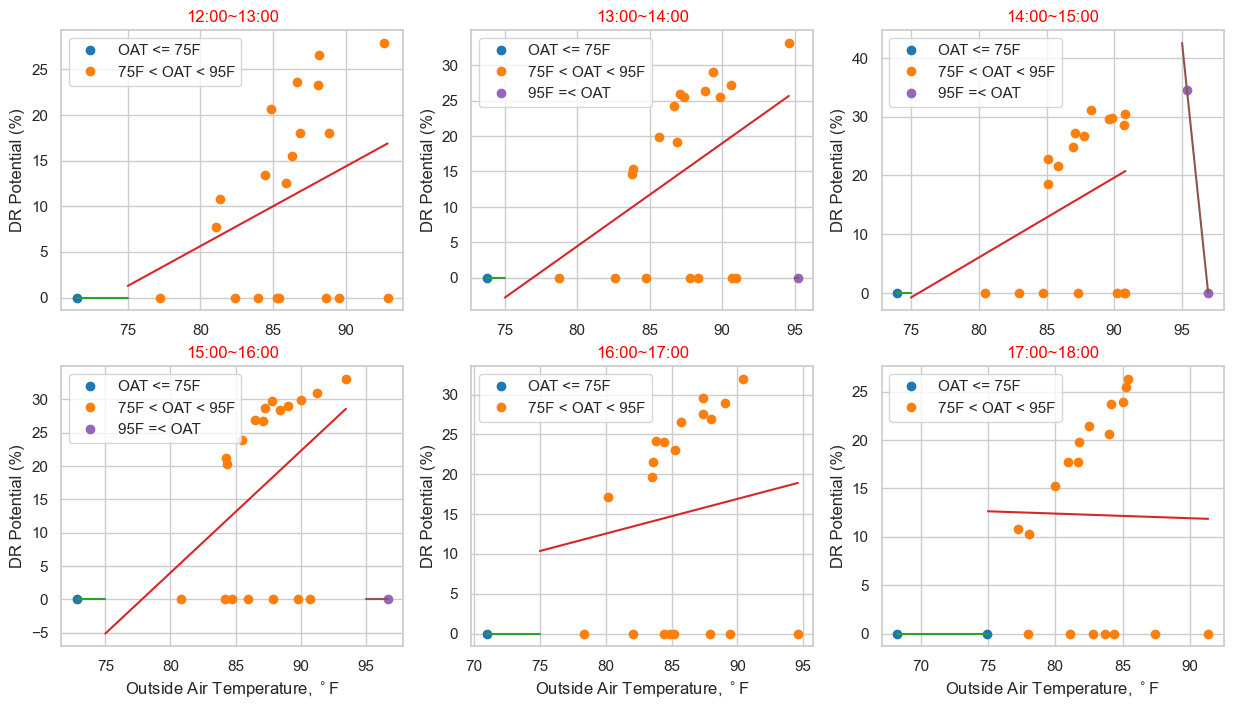

In [86]:
SetPointChanges=[2]
for SetPointChange in SetPointChanges:
    print('This is the SetPoint'+str(SetPointChange))
    from scipy import stats
    fig,axes=plt.subplots(2,3,figsize=[15,8])
    DRPercentHourlyOATResults2Deg=DRPercentHourlyOATResults[(DRPercentHourlyOATResults['SetPointChange']==SetPointChange)]

    for i in range(12,18,1):
            x1 = DRPercentHourlyOATResults2Deg.loc[(DRPercentHourlyOATResults2Deg.Hour == i) & (DRPercentHourlyOATResults2Deg.AmbientTempF <= 75), ['AmbientTempF','DRPercent']].AmbientTempF
            y1 = DRPercentHourlyOATResults2Deg.loc[(DRPercentHourlyOATResults2Deg.Hour == i) & (DRPercentHourlyOATResults2Deg.AmbientTempF <= 75), ['AmbientTempF','DRPercent']].DRPercent
            x2 = DRPercentHourlyOATResults2Deg.loc[(DRPercentHourlyOATResults2Deg.Hour == i) & (DRPercentHourlyOATResults2Deg.AmbientTempF >= 75) & (DRPercentHourlyOATResults2Deg.AmbientTempF <= 95), ['AmbientTempF','DRPercent']].AmbientTempF
            y2 = DRPercentHourlyOATResults2Deg.loc[(DRPercentHourlyOATResults2Deg.Hour == i) & (DRPercentHourlyOATResults2Deg.AmbientTempF >= 75) & (DRPercentHourlyOATResults2Deg.AmbientTempF <= 95),['AmbientTempF','DRPercent']].DRPercent
            x3 = DRPercentHourlyOATResults2Deg.loc[(DRPercentHourlyOATResults2Deg.Hour == i) & (DRPercentHourlyOATResults2Deg.AmbientTempF >= 95),['AmbientTempF','DRPercent']].AmbientTempF
            y3 = DRPercentHourlyOATResults2Deg.loc[(DRPercentHourlyOATResults2Deg.Hour == i) & (DRPercentHourlyOATResults2Deg.AmbientTempF >= 95),['AmbientTempF','DRPercent']].DRPercent

            breaks = [75,95]
            # Two linear regression functions at the breakpoint 70F
            z1 = np.polyfit(x1, y1, 1)
            p1 = np.poly1d(z1)
            xp1 = np.linspace(min(x1), breaks[0], 100)
            slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1,y1)
            z1_err = [r_value1**2, std_err1]
            r_err1 = abs(((x1 * slope1 + intercept1)-y1) / y1)
            #print(r_err1)
            z2 = np.polyfit(x2, y2, 1)
            p2 = np.poly1d(z2)
            xp2 = np.linspace(breaks[0], max(x2), 100)
            slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2,y2)
            z2_err = [r_value2**2, std_err2]
            r_err2 = abs(((x2 * slope2 + intercept2)-y2) / y2)
            #print(r_err2)
            axes.ravel()[i-12].plot(x1, y1, 'o', label = 'OAT <= 75F')
            axes.ravel()[i-12].plot(x2, y2, 'o', label = '75F < OAT < 95F')
            #axes.ravel()[i-12].set_ylim(-60,0)
            axes.ravel()[i-12].plot(xp1, p1(xp1), '-')
            axes.ravel()[i-12].plot(xp2, p2(xp2), '-')
            axes.ravel()[i-12].set_title(str(i)+':00'+'~'+str(i+1)+':00',color='red')

            if x3.size != 0:
                z3 = np.polyfit(x3, y3, 1)
                p3 = np.poly1d(z3)
                xp3 = np.linspace(breaks[1], max(x3), 100)
                slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(x3,y3)
                z3_err = [r_value3**2, std_err3]
                r_err3 = abs(((x3 * slope3 + intercept3)-y3) / y3)
                #print(r_err3)
                axes.ravel()[i-12].plot(x3, y3, 'o', label = '95F =< OAT')
                axes.ravel()[i-12].plot(xp3, p3(xp3), '-')

            #axes.ravel()[i-14].set_title('Piecewise Linear Regression at hour'+str(i)+':00')
            if i > 14:
                axes.ravel()[i-12].set_xlabel('Outside Air Temperature, $^\circ$F')
            axes.ravel()[i-12].set_ylabel('DR Potential (%)')
            axes.ravel()[i-12].legend(loc='upper left')
            print(str(i)+'-'+str(i+1)+'PM'
                 +'&'+str("{0:.2f}".format(intercept1))+'&'+str("{0:.2f}".format(slope1))+'&'+str("{0:.2f}".format(z1_err[0]))+'&'+str("{0:.2f}".format(z1_err[1]))
                 +'&'+str("{0:.2f}".format(intercept2))+'&'+str("{0:.2f}".format(slope2))+'&'+str("{0:.2f}".format(z2_err[0]))+'&'+str("{0:.2f}".format(z2_err[1]))
                 +'&'+str("{0:.2f}".format(intercept3))+'&'+str("{0:.2f}".format(slope3))+'&'+str("{0:.2f}".format(z3_err[0]))+'&'+str("{0:.2f}".format(z3_err[1]))
                 )
    fig.savefig('data/chapter3/chapter3.2/figures/'+str(SetPointChange)+'Degree.png',dpi=200, format='png')

In [4]:
wh=Waterheater(1/60)
ref=Refrigerator(1/60)

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/810203858.py:231: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/810203858.py:134: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]


In [5]:
# JUST A SAMPLE SIMULATION OF A DR EVENT:
toff_ref=[]
toff_1_ref=[]
internal_temp_ref=[]
internal_temp_ref_DR=[]
ref_setpoint_DR=[]
ref_setpoint=[]
wh_setpoint_DR=[]
wh_setpoint=[]

power_ref=[]
power_ref_DR=[]

toff_wh=[]
toff_1_wh=[]
internal_temp_wh=[]
internal_temp_wh_DR=[]
power_wh=[]
power_wh_DR=[]

eventStartTimes=[6*60,18*60,30*60,42*60,60*60]
eventEndTimes=[elem+60 for elem in eventStartTimes]
duration=range(60*72)
for i in duration:
    
    if i in eventStartTimes:
            print('changing setpoint')
            ref.changeDRSetPoint(1-ref.setpoint)
            wh.changeDRSetPoint(wh.setpoint-1)

    if i in eventEndTimes:
            ref.changeDRSetPoint(ref.setpoint)
            wh.changeDRSetPoint(wh.setpoint)   
           
    ref.get_toff()
    ref.next_interior()
    ref.next_interior_DR()
    
    wh.get_toff()
    wh.next_interior()
    wh.next_interior_DR()
    
    internal_temp_ref.append(ref.interior_temp)
    internal_temp_ref_DR.append(ref.interior_temp_DR)
    toff_ref.append(ref.toff)
    power_ref.append(ref.power*ref.status)
    power_ref_DR.append(ref.power*ref.status_DR)
    toff_1_ref.append(ref.toff_1)
    ref_setpoint_DR.append(ref.setpoint_DR)
    ref_setpoint.append(ref.setpoint)
   
    internal_temp_wh.append(wh.interior_temp)
    internal_temp_wh_DR.append(wh.interior_temp_DR)
    toff_wh.append(wh.toff)
    power_wh.append(wh.power*wh.status)
    power_wh_DR.append(wh.power*wh.status_DR)    
    toff_1_wh.append(wh.toff_1)
    wh_setpoint_DR.append(wh.setpoint_DR)
    wh_setpoint.append(wh.setpoint)

changing setpoint
changing setpoint
changing setpoint
changing setpoint
changing setpoint


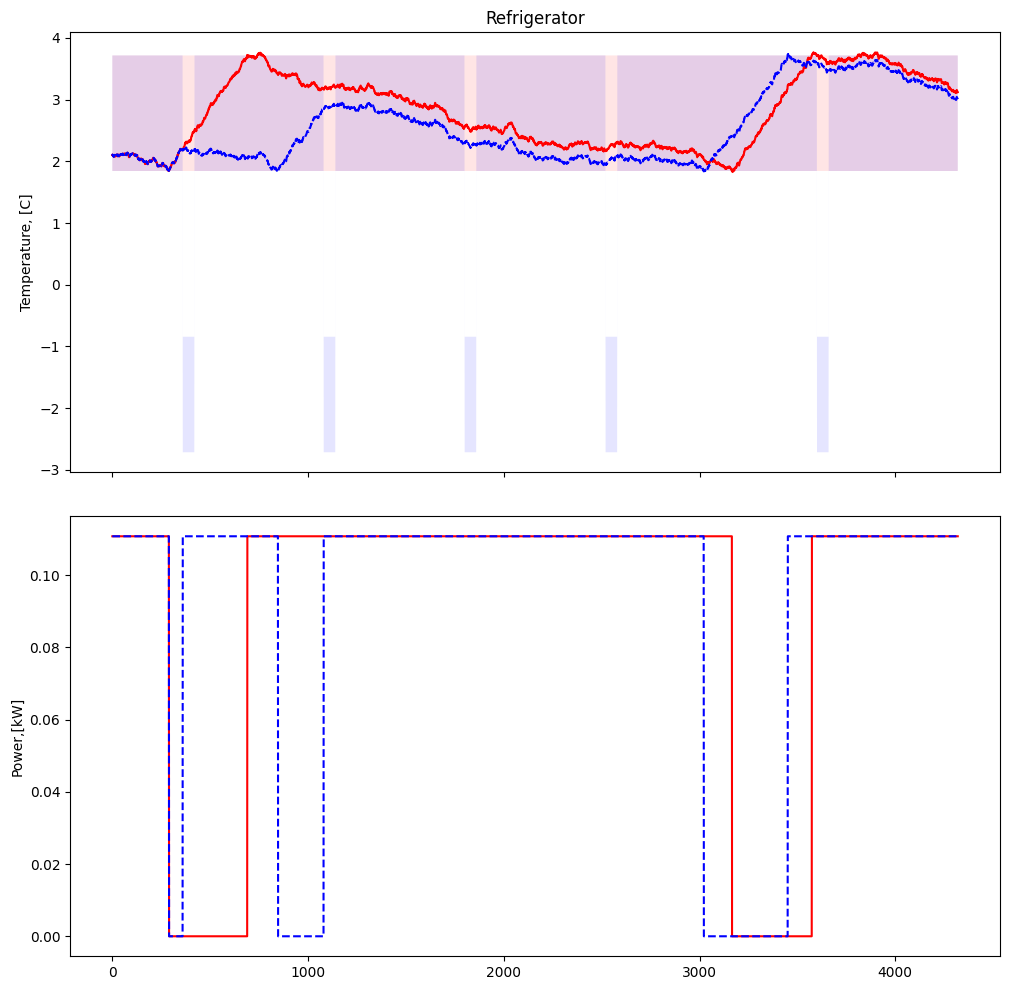

In [7]:
fig, axs = plt.subplots(2,1, figsize=(12, 12), facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .1, wspace=.001)

axs[0].set_title('Refrigerator')
axs[0].plot(internal_temp_ref,'r')
axs[0].plot(internal_temp_ref_DR,'--b')
axs[0].fill_between(duration,ref_setpoint-ref.deadbandwidth/2, ref_setpoint+ref.deadbandwidth/2,facecolor='red',alpha=0.1)
axs[0].fill_between(duration,ref_setpoint_DR-ref.deadbandwidth/2, ref_setpoint_DR+ref.deadbandwidth/2,facecolor='blue',alpha=0.1)

axs[0].set_ylabel('Temperature, [C]')

axs[1].plot(power_ref,'r')
axs[1].plot(power_ref_DR,'--b')
axs[1].set_ylabel('Power,[kW]')

fig.savefig('data/chapter3/chapter3.2/figures/Sample_Refrigerator.png', dpi=200, format='png',bbox_inches='tight')
plt.show()

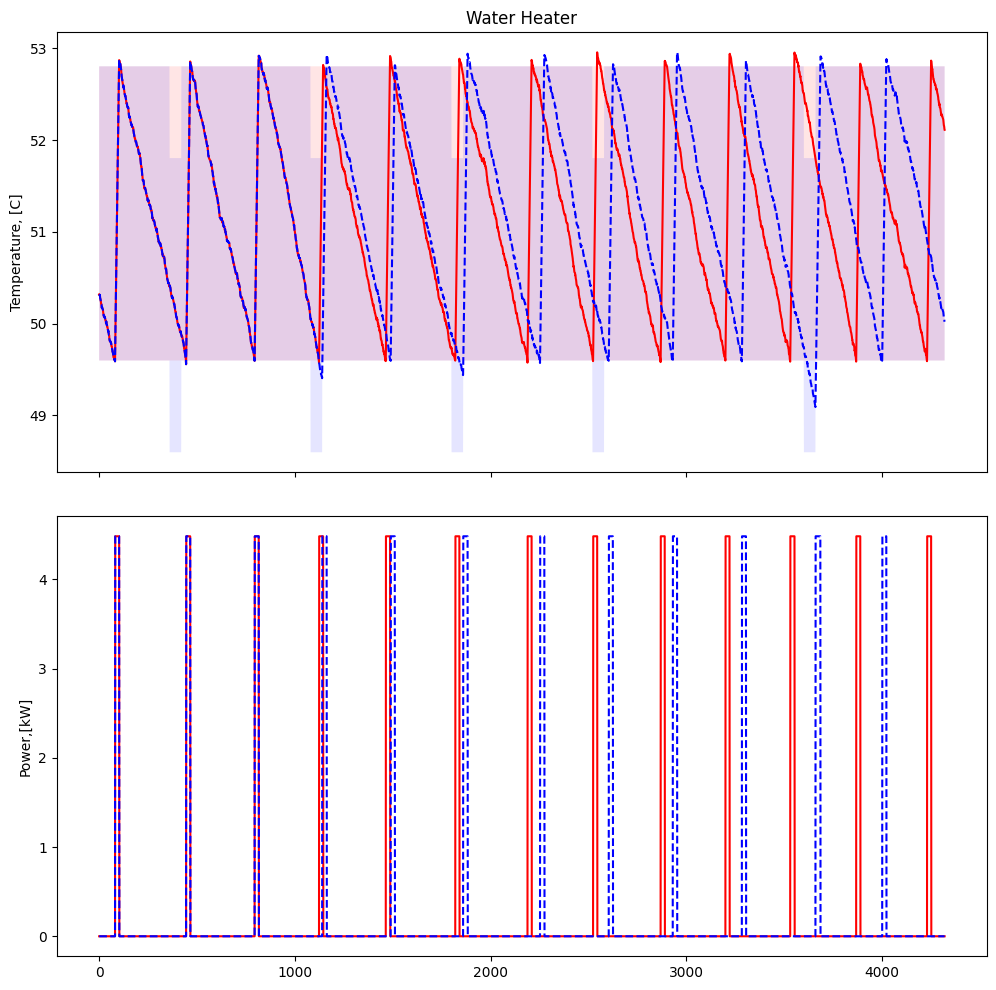

In [8]:
fig, axs = plt.subplots(2,1, figsize=(12, 12), facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .1, wspace=.001)

axs[0].set_title('Water Heater')
axs[0].plot(internal_temp_wh,'r')
axs[0].plot(internal_temp_wh_DR,'--b')
axs[0].fill_between(duration,wh_setpoint-wh.deadbandwidth/2, wh_setpoint+wh.deadbandwidth/2,facecolor='red',alpha=0.1)
axs[0].fill_between(duration,wh_setpoint_DR-wh.deadbandwidth/2, wh_setpoint_DR+wh.deadbandwidth/2,facecolor='blue',alpha=0.1)

axs[0].set_ylabel('Temperature, [C]')

axs[1].plot(power_wh,'r')
axs[1].plot(power_wh_DR,'--b')
axs[1].set_ylabel('Power,[kW]')

fig.savefig('data/chapter3/chapter3.2/figures/Sample_Waterheater.png', dpi=200, format='png',bbox_inches='tight')
plt.show()

In [26]:
#Initialize individual TCLs
number_of_tcls=1000
step=2 #in minutes
timestep=step/60 #in hours
duration=3 #in hours
### KEEP THESE THE SAME

# Initialize a set of TCLs
results=[]
setPointChanges=[1,2,3,-1,-2,-3]
duration=range(0,60*duration,step)
eventStartTimes=[1*60] # in minutes 
eventEndTimes=[elem+60 for elem in eventStartTimes]

for SetPointChange in setPointChanges:
    curDate=datetime.datetime(year=2015,month=1,day=1,hour=0,minute=0)
    list_of_tcls=[]
    # INITIALIZE A SET OF TCLs 
    for elem in range(number_of_tcls):
        list_of_tcls.append(Refrigerator(timestep))
        list_of_tcls.append(Waterheater(timestep))
        # list_of_tcls.append(Airconditioner(timestep,23)) # Airconditioner with a setpoint of 23C
    hr=0
    for i in duration:  
        if i in eventStartTimes:
            print('changing setpoint')
            for ref in list_of_tcls:
                ref.changeDRSetPoint(ref.setpoint+SetPointChange)

        if i in eventEndTimes:
            print('changing setpoint')
            for ref in list_of_tcls:
                ref.changeDRSetPoint(ref.setpoint)

        if i % 60 == 0:
            hr=hr+1
            print('Simulated '+str(hr)+' hours.')
        for ref in list_of_tcls:
            #ref.get_toff()
            ref.next_interior()
            ref.next_interior_DR()

            resDict={}
            resDict['InteriorTemp']=ref.interior_temp
            resDict['InternalTempDR']=ref.interior_temp_DR
            resDict['Resistance']=ref.resistance
            resDict['Capacitance']=ref.capacitance
            resDict['DeadBandWidth']=ref.deadbandwidth

            #toff_ref.append(ref.toff)
            resDict['CurrentPower']=ref.power*ref.status
            resDict['CurrentPowerDR']=ref.power*ref.status_DR
            resDict['DRPercent']=((ref.power*ref.status_DR)-(ref.power*ref.status))*100/ref.power #DR-Nominal
            resDict['RatedPower']=ref.power
            resDict['SetPoint']=ref.setpoint
            resDict['SetPointDR']=ref.setpoint_DR
            resDict['Type']=ref.type
            resDict['Id']=ref.id
            resDict['Minute']=i
            resDict['Date']=curDate
            resDict['SetPointChange']=SetPointChange
            results.append(resDict)
        curDate=curDate+datetime.timedelta(minutes=step)
results=pd.DataFrame(results)   

def getHour(row):
    return row['Date'].hour

results['Hour']=results.apply(getHour,axis=1)  

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/810203858.py:134: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/810203858.py:231: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]


Simulated 1 hours.
changing setpoint
Simulated 2 hours.
changing setpoint
Simulated 3 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
changing setpoint
Simulated 3 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
changing setpoint
Simulated 3 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
changing setpoint
Simulated 3 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
changing setpoint
Simulated 3 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
changing setpoint
Simulated 3 hours.


In [27]:
results['Id'].unique()

array(['REF1802', 'WH1802', 'REF1803', ..., 'WH7800', 'REF7801', 'WH7801'],
      dtype=object)

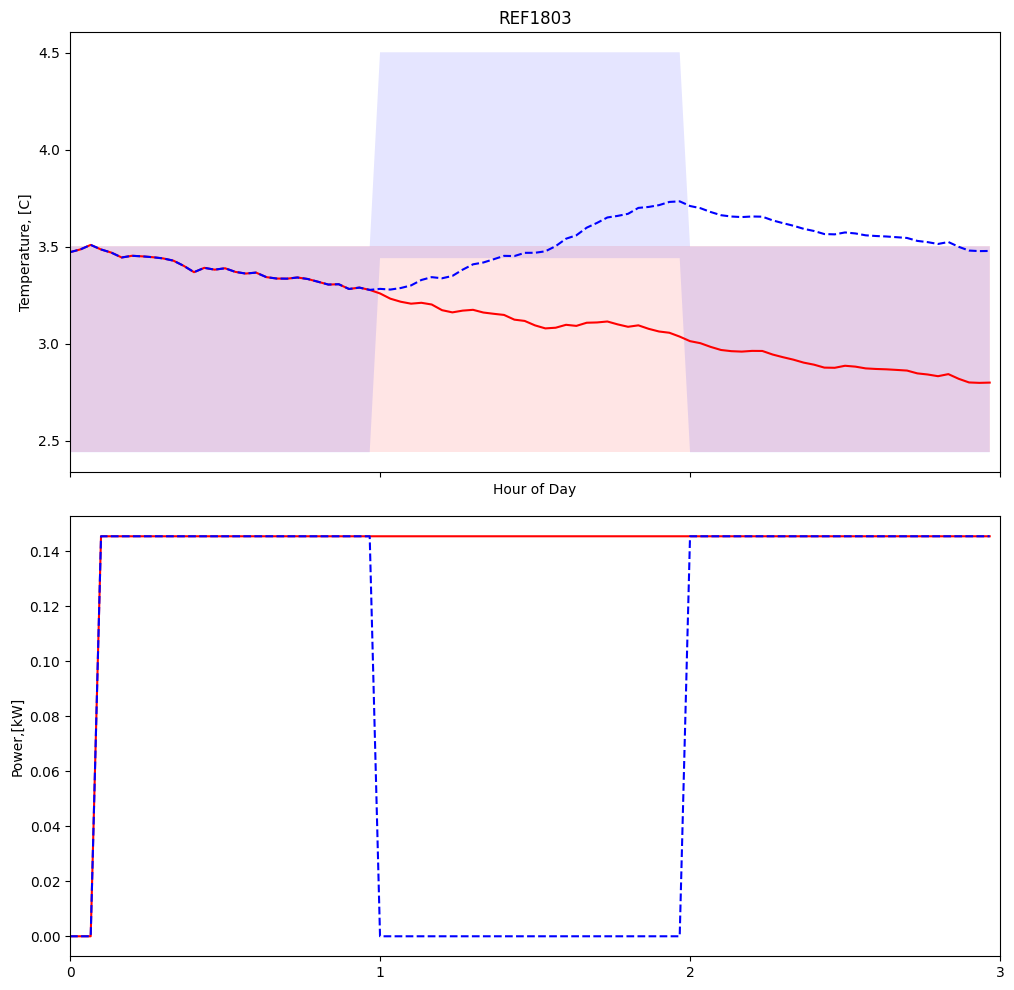

In [30]:
tclid='REF1803'
subSample=results[results['Id']==tclid]
fig, axs = plt.subplots(2,1, figsize=(12, 12), facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .1, wspace=.001)

axs[0].set_title(tclid)
axs[0].plot(subSample['Minute']/60,subSample['InteriorTemp'],'r')
axs[0].plot(subSample['Minute']/60,subSample['InternalTempDR'],'--b')
axs[0].fill_between(subSample['Minute']/60,subSample['SetPoint']-subSample['DeadBandWidth']/2, subSample['SetPoint']+subSample['DeadBandWidth']/2,facecolor='red',alpha=0.1)
axs[0].fill_between(subSample['Minute']/60,subSample['SetPointDR']-subSample['DeadBandWidth']/2, subSample['SetPointDR']+subSample['DeadBandWidth']/2,facecolor='blue',alpha=0.1)

axs[0].set_ylabel('Temperature, [C]')

axs[1].plot(subSample['Minute']/60,subSample['CurrentPower'],'r')
axs[1].plot(subSample['Minute']/60,subSample['CurrentPowerDR'],'--b')
axs[1].set_ylabel('Power,[kW]')

axs[0].set_xlim([0,3])
axs[0].xaxis.set_ticks(np.arange(0, 4, 1))
axs[0].set_xlabel('Hour of Day')
fig.savefig('data/chapter3/chapter3.2/figures/Unit'+str(tclid)+'.png', dpi=200, format='png',bbox_inches='tight')
plt.show()

In [34]:
def chunks(l,n):
    n = max(1, n)
    return [l[i:i + n] for i in range(0, len(l), n)]

Types=['Refrigerator','Waterheater']
cluster_sizes=[10,25,50,100,250,500]
GroupResultsList=[]
GroupResults=results[(results['Hour']==1)]
for SetPointChange in setPointChanges:
    for Type in Types:
        SubGroupResults=GroupResults[(GroupResults['Type']==Type) & (GroupResults['SetPointChange']==SetPointChange)]
        print(len(SubGroupResults))
        for n in cluster_sizes:
            listOfIds=chunks(SubGroupResults['Id'].unique(),n)
            ctr=0
            for k in listOfIds:
                SelectedGroupResults=SubGroupResults[SubGroupResults['Id'].isin(k)]
                AvePower=SelectedGroupResults.groupby(['Id','Hour','Resistance','Capacitance','DeadBandWidth'])[['DRPercent','CurrentPower']].mean()
                AvePowerDF = AvePower.reset_index()
                SumDRPotential=AvePowerDF.groupby(['Hour'])[['DRPercent','CurrentPower']].sum()
                #print(SumDRPotential)
                SumDRPotentialDF=SumDRPotential.reset_index()
                #print(SumDRPotential['PowerDiff'].values[0])
                GroupRes={}
                #print(SumDRPotentialDF)
                GroupRes['TotalDR']=SumDRPotentialDF['DRPercent'].values[0]#/SumDRPotentialDF['CurrentPower'].values[0]
                GroupRes['Type']=Type#/SumDRPotentialDF['CurrentPower'].values[0]
                GroupRes['SetPointChange']=SetPointChange#/SumDRPotentialDF['CurrentPower'].values[0]
                GroupRes['ClusterSize']=n
                GroupResultsList.append(GroupRes)
                #print('Done with '+str(ctr/len(listOfIds)))
                ctr=ctr+1
GroupResults=pd.DataFrame(GroupResultsList)


30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000


In [35]:
means=GroupResults.groupby(['Type','ClusterSize','SetPointChange'])['TotalDR'].mean()
stds=GroupResults.groupby(['Type','ClusterSize','SetPointChange'])['TotalDR'].std()

meansDF=pd.DataFrame(means).reset_index()
meansDF = meansDF.rename(columns={'TotalDR': 'TotalDRAVE'})

stdsDF=pd.DataFrame(stds).reset_index()
stdsDF=stdsDF.rename(columns={'TotalDR': 'TotalDRSTD'})

JoinedDF=pd.merge(stdsDF,meansDF, on=['Type','ClusterSize','SetPointChange'],how='left')





[1, 2, 3, -1, -2, -3]
plotting water heater
plotting water heater
plotting water heater
plotting water heater
plotting water heater
plotting water heater


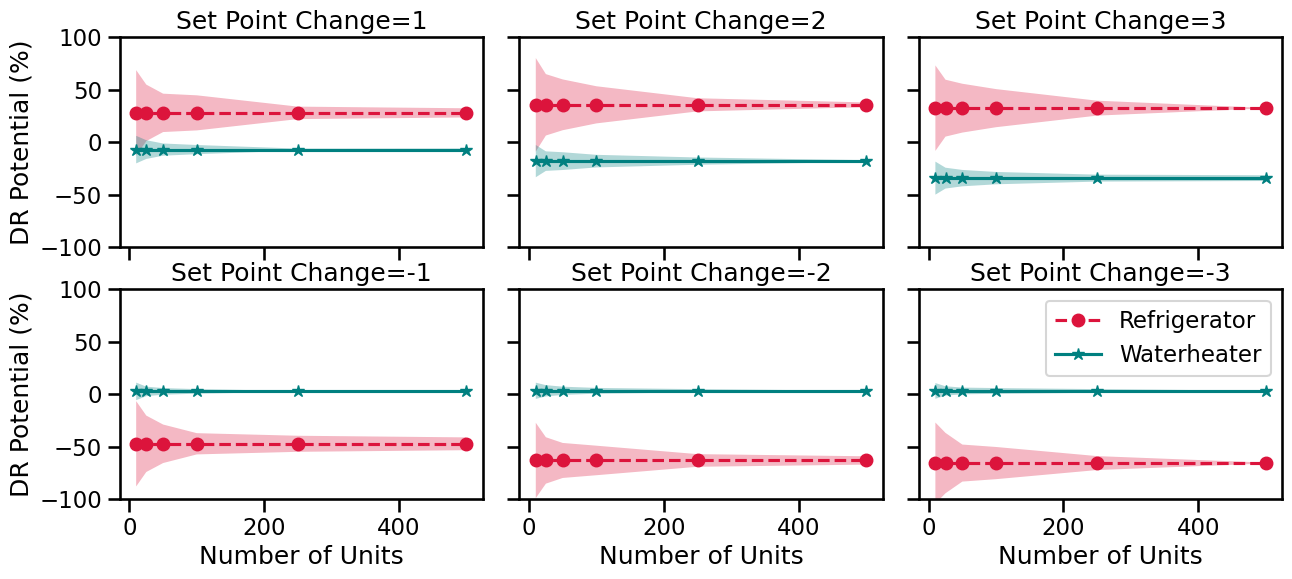

In [36]:
sns.set_context('talk')
fig, axs = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k',sharex=True,sharey=True)
fig.subplots_adjust(hspace = .2, wspace=.1)

axs = axs.ravel()
i=0
print(setPointChanges)
for SetPointChange in setPointChanges:
    for Type in Types:
        joinedData=JoinedDF[(JoinedDF['SetPointChange']==SetPointChange) & (JoinedDF['Type']==Type)]
        joinedData=joinedData[joinedData['Type']==Type]
        if Type=='Refrigerator':
            axs[i].set_title('Set Point Change='+str(SetPointChange))
            axs[i].plot(joinedData['ClusterSize'], -1*joinedData['TotalDRAVE']/joinedData['ClusterSize'],'--o',color='crimson',label=Type)
            axs[i].fill_between(joinedData['ClusterSize'], -1*(joinedData['TotalDRAVE']+3*joinedData['TotalDRSTD'])/joinedData['ClusterSize'],-1*(joinedData['TotalDRAVE']-3*joinedData['TotalDRSTD'])/joinedData['ClusterSize'],facecolor='crimson',alpha=0.3)
            #axs.set_xscale("log")
            if ((i==0) | (i==3)):
                axs[i].set_ylabel("DR Potential (%)")
            if (i>2):
                axs[i].set_xlabel("Number of Units")
        if Type=='Waterheater':
            print('plotting water heater')
            axs[i].plot(joinedData['ClusterSize'], -1*joinedData['TotalDRAVE']/joinedData['ClusterSize'],'-*',color='teal',label=Type)
            axs[i].fill_between(joinedData['ClusterSize'], -1*(joinedData['TotalDRAVE']+3*joinedData['TotalDRSTD'])/joinedData['ClusterSize'],-1*(joinedData['TotalDRAVE']-3*joinedData['TotalDRSTD'])/joinedData['ClusterSize'],facecolor='teal',alpha=0.3)
            #axs.set_xscale("log")
            #axs[i].set_ylabel("DR Potential (%)")
            #axs[i].set_xlabel("Number of Units")
        if i==5:
            axs[i].legend()
        axs[i].set_ylim([-100,100])
    i=i+1  
fig.savefig('data/chapter3/chapter3.2/figures/RefWaterHeaterPotential.png', dpi=200, format='png')

## Uniform Sampling of Outside Air Temperature

In [89]:
#Initialize individual TCLs
number_of_tcls=500
step=2 #in minutes
timestep=step/60 #in hours
duration=2 #in hours
### KEEP THESE THE SAME

# Initialize a set of TCLs
results=[]
setPointChanges=[1,2,3,-1,-2,-3]
duration=range(0,60*duration,step)
eventStartTimes=[1*60] # in minutes 
eventEndTimes=[elem+60 for elem in eventStartTimes]
AmbientTemps=np.random.uniform(17,28,50)
for ambientTemp in AmbientTemps:
    for SetPointChange in setPointChanges:
        curDate=datetime.datetime(year=2015,month=1,day=1,hour=0,minute=0)
        list_of_tcls=[]
        # INITIALIZE A SET OF TCLs 
        for elem in range(number_of_tcls):
            list_of_tcls.append(Refrigerator(timestep,ambient_temp=ambientTemp))
            list_of_tcls.append(Waterheater(timestep,ambient_temp=ambientTemp))
            # list_of_tcls.append(Airconditioner(timestep,23))
        hr=0
        for i in duration:  
            if i in eventStartTimes:
                print('changing setpoint')
                for ref in list_of_tcls:
                    ref.changeDRSetPoint(ref.setpoint+SetPointChange)

            if i in eventEndTimes:
                print('changing setpoint')
                for ref in list_of_tcls:
                    ref.changeDRSetPoint(ref.setpoint)

            if i % 60 == 0:
                hr=hr+1
                print('Simulated '+str(hr)+' hours.')
            for ref in list_of_tcls:
                #ref.get_toff()
                ref.next_interior()
                ref.next_interior_DR()

                resDict={}
                resDict['InteriorTemp']=ref.interior_temp
                resDict['InternalTempDR']=ref.interior_temp_DR
                resDict['Resistance']=ref.resistance
                resDict['Capacitance']=ref.capacitance
                resDict['DeadBandWidth']=ref.deadbandwidth

                #toff_ref.append(ref.toff)
                resDict['CurrentPower']=ref.power*ref.status
                resDict['CurrentPowerDR']=ref.power*ref.status_DR
                resDict['DRPercent']=((ref.power*ref.status_DR)-(ref.power*ref.status))*100/ref.power #DR-Nominal
                resDict['RatedPower']=ref.power
                resDict['SetPoint']=ref.setpoint
                resDict['SetPointDR']=ref.setpoint_DR
                resDict['Type']=ref.type
                resDict['Id']=ref.id
                resDict['Minute']=i
                resDict['Date']=curDate
                resDict['SetPointChange']=SetPointChange
                resDict['AmbientTemp']=ambientTemp

                results.append(resDict)
            curDate=curDate+datetime.timedelta(minutes=step)
results=pd.DataFrame(results)   

def getHour(row):
    return row['Date'].hour

results['Hour']=results.apply(getHour,axis=1)  

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:134: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/3295229507.py:231: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  self.status=np.random.random_integers(0,1,1)[0]


Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2 hours.
Simulated 1 hours.
changing setpoint
Simulated 2

In [93]:
def chunks(l,n):
    n = max(1, n)
    return [l[i:i + n] for i in range(0, len(l), n)]

Types=['Refrigerator','Waterheater']
cluster_sizes=[500]
GroupResultsList=[]
GroupResults=results[(results['Hour']==1)]
for ambientTemp in AmbientTemps:
    for SetPointChange in setPointChanges:
        for Type in Types:
            SubGroupResults=GroupResults[(GroupResults['Type']==Type) & (GroupResults['SetPointChange']==SetPointChange)& (GroupResults['AmbientTemp']==ambientTemp)]
            #print(len(SubGroupResults))
            for n in cluster_sizes:
                listOfIds=chunks(SubGroupResults['Id'].unique(),n)
                ctr=0
                for k in listOfIds:
                    SelectedGroupResults=SubGroupResults[SubGroupResults['Id'].isin(k)]
                    AvePower=SelectedGroupResults.groupby(['Id','Hour','Resistance','Capacitance','DeadBandWidth'])[['DRPercent','CurrentPower']].mean()
                    AvePowerDF = AvePower.reset_index()
                    SumDRPotential=AvePowerDF.groupby(['Hour'])[['DRPercent','CurrentPower']].sum()
                    #print(SumDRPotential)
                    SumDRPotentialDF=SumDRPotential.reset_index()
                    #print(SumDRPotential['PowerDiff'].values[0])
                    GroupRes={}
                    #print(SumDRPotentialDF)
                    GroupRes['TotalDR']=SumDRPotentialDF['DRPercent'].values[0]#/SumDRPotentialDF['CurrentPower'].values[0]
                    GroupRes['Type']=Type#/SumDRPotentialDF['CurrentPower'].values[0]
                    GroupRes['SetPointChange']=SetPointChange#/SumDRPotentialDF['CurrentPower'].values[0]
                    GroupRes['ClusterSize']=n
                    GroupRes['AmbientTemp']=ambientTemp
                    GroupResultsList.append(GroupRes)
                    #print('Done with '+str(ctr/len(listOfIds)))
                    ctr=ctr+1
GroupResults=pd.DataFrame(GroupResultsList)


In [99]:
sns.set_context('poster')
def FFromCelsius(row):
    return row['AmbientTemp']*1.8+32
def GetDRPercent(row):
    return -1*row['TotalDR']/row['ClusterSize']

<>:70: SyntaxWarning: invalid escape sequence '\c'
<>:71: SyntaxWarning: invalid escape sequence '\c'
<>:72: SyntaxWarning: invalid escape sequence '\c'
<>:77: SyntaxWarning: invalid escape sequence '\c'
<>:70: SyntaxWarning: invalid escape sequence '\c'
<>:71: SyntaxWarning: invalid escape sequence '\c'
<>:72: SyntaxWarning: invalid escape sequence '\c'
<>:77: SyntaxWarning: invalid escape sequence '\c'
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/4184876460.py:70: SyntaxWarning: invalid escape sequence '\c'
  axes.ravel()[i].plot(temps,Tset1, 'o-', label = 'AC, OAT <= 75$^\circ$F(23.9$^\circ$C)')
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/4184876460.py:71: SyntaxWarning: invalid escape sequence '\c'
  axes.ravel()[i].plot(temps,Tset2, 'o-', label = 'AC, 75$^\circ$F(23.9$^\circ$C) < OAT < 95$^\circ$F(35.0$^\circ$C)')
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_30718/4184876460.py:72: SyntaxWarning: invalid escape sequence '\c'
 

This is the typeRefrigerator
This is the typeWaterheater
This is the typeAC


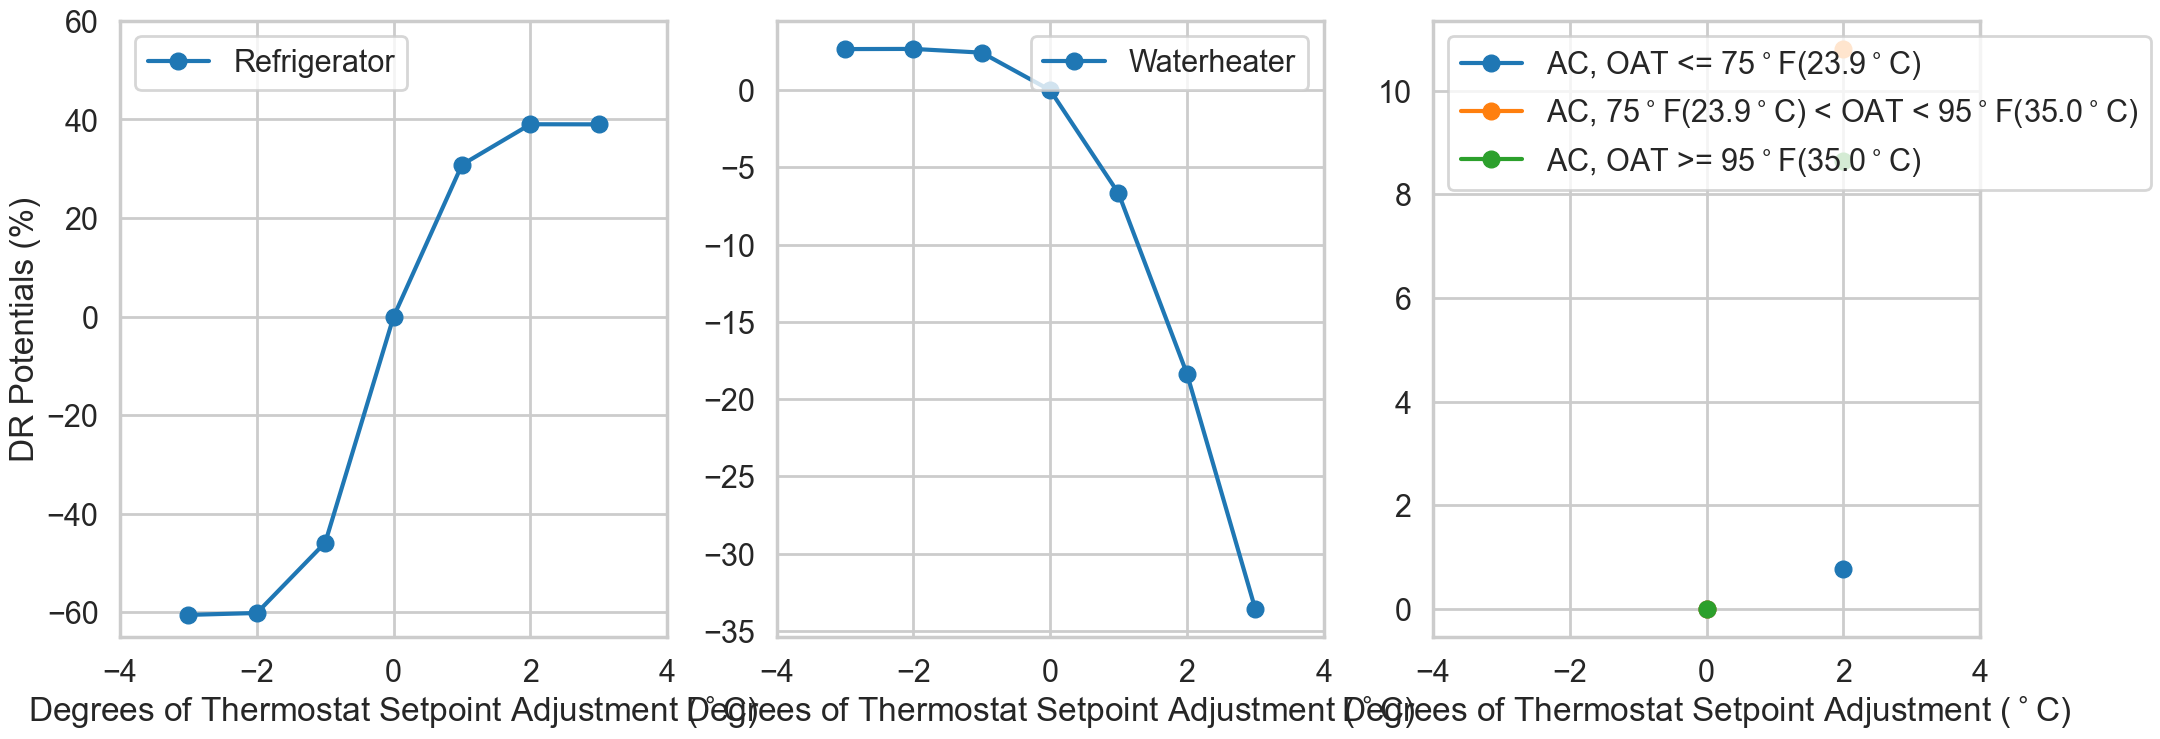

In [98]:
sns.set_context('poster')
temps=[-3,-2,-1,0,1,2,3]
GroupResults['AmbientTempF']=GroupResults.apply(FFromCelsius,axis=1)
GroupResults['DRPercent']=GroupResults.apply(GetDRPercent,axis=1)

#GroupResults2=GroupResults[GroupResults['SetPointChange']==2]
GroupResultsAll=GroupResults[['AmbientTempF','DRPercent','Type','SetPointChange']]

# GET THE AC RESULTS
DRPercentHourlyOATResults=pd.read_pickle('data/chapter3/chapter3.2/ACSetPointOATDRFirstWeekOfMultiDayTest.pkl')
DRPercentHourlyOATResults['Type']='AC'
DRPercentHourlyOATResults['DRPercent']=DRPercentHourlyOATResults['DRPercent']*-1
DRPercentHourlyOATResults['AmbientTempF']=DRPercentHourlyOATResults.apply(FFromCelsius,axis=1)

FromACs=DRPercentHourlyOATResults[['AmbientTempF','DRPercent','Type','SetPointChange']]

GroupResultsAll=pd.concat([FromACs,GroupResultsAll])

i=0
fig,axes=plt.subplots(1,3,figsize=[24,8])
Types=['Refrigerator','Waterheater','AC']

for typ in Types:
    DRPercentHourlyOATResults=GroupResultsAll[GroupResultsAll['Type']==typ]
    print('This is the type'+typ)
    if i<2:
        Tset1=[]
        # 1 and -1 degrees reset
        for elem in temps:
            if (elem == 0):
                Tset1.append(0)
            else:        
                y1 = DRPercentHourlyOATResults.loc[(DRPercentHourlyOATResults.SetPointChange == elem), ['AmbientTempF','DRPercent']].DRPercent
                Tset1.append(y1.mean())
        #print(Tset1)   
        #print(len(temps),len(Tset1))
        axes.ravel()[i].plot(temps,Tset1, 'o-', label = typ)
        #axes[i].set_title(str(i)+':00'+'~'+str(i+1)+':00',color='red')
        axes.ravel()[i].set_xlim(-4,4)
        if i==0:
            axes.ravel()[i].set_ylabel('DR Potentials (%)')
            axes.ravel()[i].legend(loc='upper left')
            axes.ravel()[i].set_ylim(-65,60)

        else:
            axes.ravel()[i].legend(loc='upper right')


    
    else:
        Tset1=[]
        Tset2=[]
        Tset3=[]
        # 1 and -1 degrees reset
        for elem in temps:
            if (elem == 0):
                Tset1.append(0)
                Tset2.append(0)
                Tset3.append(0)
            else:        
                y1 = DRPercentHourlyOATResults.loc[ (DRPercentHourlyOATResults.AmbientTempF <= 75) & (DRPercentHourlyOATResults.SetPointChange == elem), ['AmbientTempF','DRPercent']].DRPercent
                y2 = DRPercentHourlyOATResults.loc[ (DRPercentHourlyOATResults.AmbientTempF >= 75) & (DRPercentHourlyOATResults.SetPointChange == elem) & (DRPercentHourlyOATResults.AmbientTempF <= 95), ['AmbientTempF','DRPercent']].DRPercent
                y3 = DRPercentHourlyOATResults.loc[ (DRPercentHourlyOATResults.AmbientTempF >= 95) & (DRPercentHourlyOATResults.SetPointChange == elem),['AmbientTempF','DRPercent']].DRPercent

                Tset1.append(y1.mean())
                Tset2.append(y2.mean())
                Tset3.append(y3.mean())
        #print(Tset1)   
        #print(len(temps),len(Tset1))
        axes.ravel()[i].plot(temps,Tset1, 'o-', label = 'AC, OAT <= 75$^\circ$F(23.9$^\circ$C)')
        axes.ravel()[i].plot(temps,Tset2, 'o-', label = 'AC, 75$^\circ$F(23.9$^\circ$C) < OAT < 95$^\circ$F(35.0$^\circ$C)')
        axes.ravel()[i].plot(temps,Tset3, 'o-', label = 'AC, OAT >= 95$^\circ$F(35.0$^\circ$C)')
        axes.ravel()[i].set_xlim(-4,4)
        #axes[i].set_title(str(i)+':00'+'~'+str(i+1)+':00',color='red')
    #axes.ravel()[i].set_ylabel('DR Potential (%)')
        axes.ravel()[i].legend(loc='upper left')
    axes.ravel()[i].set_xlabel('Degrees of Thermostat Setpoint Adjustment ($^\circ$C)')
    i=i+1
fig.savefig('data/chapter3/chapter3.2/figures/TempAdjustAllTwoStates.png',dpi=400,bbox_inches='tight')

## Reference
R Yin, EC Kara, Y Li, N DeForest, K Wang, T Yong, M Stadler. Quantifying flexibility of commercial and residential loads for demand response using setpoint changes. Applied Energy 177, 149-164, 2016
